## Extraordinary Hackers. Gas Analysis

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from config import PROJECT_ID, DATASET_NAME, INITIAL_TS, SNAPSHOT_TS, bq_client
from utils import drop_table, create_table, get_df

DROP_TABLES = False
CREATE_TABLES = False

table_name_1 = 'gas_spend_by_contract'
table_name_2 = 'gasdrop_distribution'

### Drop Tables

In [2]:
if DROP_TABLES:
    drop_table('gas_spend_by_contract')
    drop_table('gasdrop_distribution')

### Create Table with Spending Gas by Contracts

In [3]:
query_1 = f'''
    CREATE TABLE `{PROJECT_ID}.{DATASET_NAME}.{table_name_1}` AS (
        WITH gas_spend AS (
            SELECT
                to_address,
                sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric))/1e18 as fee
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
            GROUP BY to_address
            ORDER BY fee DESC
        ),
        traces AS (
            SELECT
                transaction_hash,
                from_address,
                to_address
            FROM `bigquery-public-data.crypto_ethereum.traces`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
              AND trace_type ='create'
              AND status = 1),
        contract_creators AS (
            SELECT
                from_address as creator_address,
                `hash` as transaction_hash
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}')
        SELECT
            t.to_address as contract_address,
            if(t.from_address=cc.creator_address, null, t.from_address)  as fabric_address,
            cc.creator_address as creator_address,
            g.fee
        FROM gas_spend as g
        INNER JOIN traces as t ON g.to_address = t.to_address
        LEFT JOIN contract_creators as cc ON t.transaction_hash = cc.transaction_hash);
'''
if CREATE_TABLES:
    create_table(query_1, table_name_1)

### Create Table with Distribution by Contract and Fabric Creators

In [4]:
query_2 = f'''
    CREATE TABLE `{PROJECT_ID}.{DATASET_NAME}.{table_name_2}` AS (
        WITH fee_by_fabric AS (
            SELECT
                fabric_address,
                sum(fee) as sum_fee
            FROM `{PROJECT_ID}.{DATASET_NAME}.{table_name_1}`
            WHERE fabric_address is not null
            GROUP BY fabric_address
            ),
        fabric_creators AS (
            SELECT
                contract_address as fabric_address,
                creator_address as fabric_creator
            FROM `{PROJECT_ID}.{DATASET_NAME}.{table_name_1}`
            WHERE contract_address IN (
                SELECT DISTINCT fabric_address
                FROM `{PROJECT_ID}.{DATASET_NAME}.{table_name_1}`
                )
            )
        SELECT
            'fabric' as subtype,
            fabric_creator as address,
            fee_3 as sum_fee,
            CASE
                WHEN fee_3 > 10 THEN 3
                WHEN fee_3 > 0 THEN 2
                ELSE null
            END
            AS grade
        FROM (
            SELECT
                fabric_creator,
                sum(sum_fee) as fee_3
            FROM fee_by_fabric as ff
            LEFT JOIN fabric_creators as fc ON ff.fabric_address = fc.fabric_address
            GROUP BY fabric_creator)
        WHERE fabric_creator is not null
        UNION ALL
        SELECT
            'creator' as subtype,
            address,
            sum_fee,
            CASE
                WHEN sum_fee > 10 THEN 3
                WHEN sum_fee > 1 THEN 2
                WHEN sum_fee > 0 THEN 1
                ELSE null
            END
            AS grade
        FROM (
            SELECT
                creator_address as address,
                sum(fee) as sum_fee
            FROM `{PROJECT_ID}.{DATASET_NAME}.{table_name_1}`
            GROUP BY creator_address)
        WHERE address is not null
        ORDER BY sum_fee DESC);
'''

if CREATE_TABLES:
    create_table(query_2, table_name_2)

### Get Spending Fee Distribution

In [5]:
query_3 = f'''
    SELECT
        subtype,
        CASE
            WHEN sum_fee <= 0.01 THEN 0.01
            WHEN sum_fee <= 0.1 THEN 0.1
            WHEN sum_fee <= 1 THEN 1
            WHEN sum_fee <= 10 THEN 10
            WHEN sum_fee <= 100 THEN 100
            WHEN sum_fee <= 1000 THEN 1000
            WHEN sum_fee > 1000 THEN 10000
        END
        AS fee_class,
        count(address) as number_of_creators,
        cast(avg(grade) as INT64) as grade
    FROM `{PROJECT_ID}.{DATASET_NAME}.{table_name_2}`
    GROUP BY subtype, fee_class
    ORDER BY subtype, fee_class;
'''
spending_fee_distr_df = get_df(query_3, columns=['subtype', 'fee_class', 'number_of_creators', 'grade'])
spending_fee_distr_df

,subtype,fee_class,number_of_creators,grade
0,creator,0.01,346838,1
1,creator,0.10,69161,1
2,creator,1.00,39645,1
3,creator,10.00,14701,2
4,creator,100.00,5520,3
5,creator,1000.00,1446,3
6,creator,10000.00,251,3
7,fabric,0.01,1141,2
8,fabric,0.10,787,2
9,fabric,1.00,593,2


In [6]:
spending_fee_distr_by_grade_df = spending_fee_distr_df.groupby(['subtype', 'grade'])['number_of_creators'].agg(sum).reset_index()
spending_fee_distr_by_grade_df

,subtype,grade,number_of_creators
0,creator,1,455644
1,creator,2,14701
2,creator,3,7217
3,fabric,2,2940
4,fabric,3,400


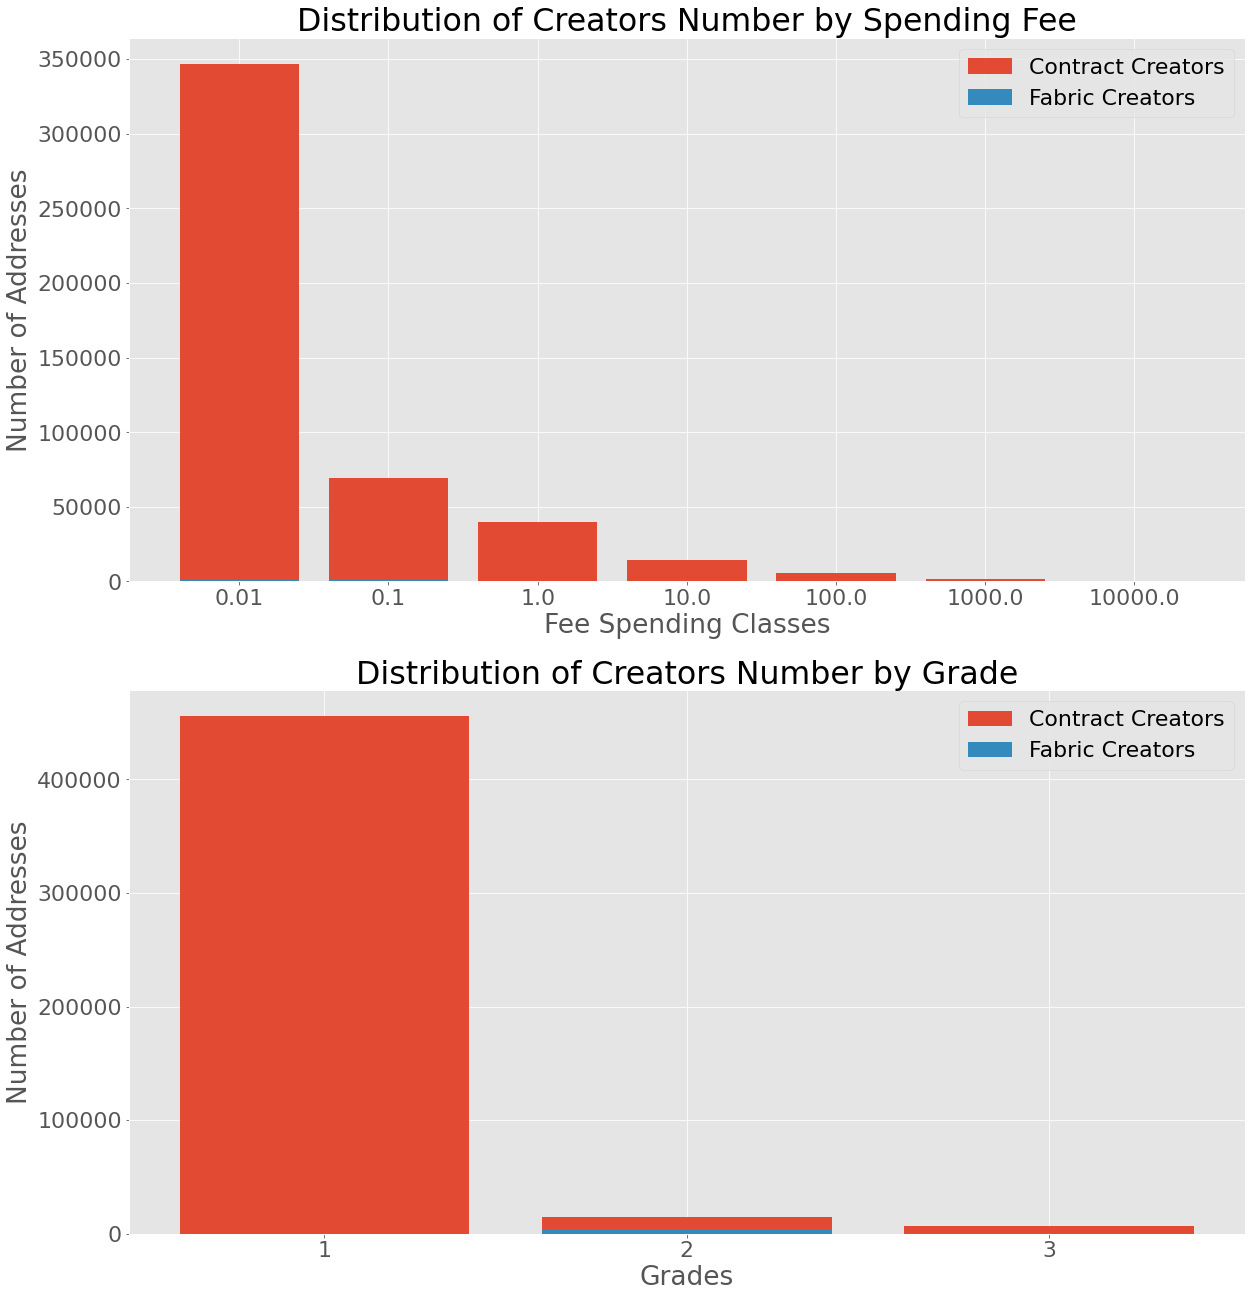

In [7]:
mpl.rcParams['figure.figsize'] = (20.0, 22.0)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2) = plt.subplots(2)
# fig.suptitle('Distribution of Creators Number by Spending Fee and Grade')

ax1.set_title('Distribution of Creators Number by Spending Fee')
ax1.bar(
    spending_fee_distr_df[spending_fee_distr_df.subtype=='creator'].fee_class.astype('str'),
    spending_fee_distr_df[spending_fee_distr_df.subtype=='creator'].number_of_creators),
ax1.bar(
    spending_fee_distr_df[spending_fee_distr_df.subtype=='fabric'].fee_class.astype('str'),
    spending_fee_distr_df[spending_fee_distr_df.subtype=='fabric'].number_of_creators)
ax1.set_ylabel('Number of Addresses')
ax1.set_xlabel('Fee Spending Classes')
ax1.legend(labels=['Contract Creators', 'Fabric Creators'])

ax2.set_title('Distribution of Creators Number by Grade')
ax2.bar(
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='creator'].grade.astype('str'),
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='creator'].number_of_creators),
ax2.bar(
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='fabric'].grade.astype('str'),
    spending_fee_distr_by_grade_df[spending_fee_distr_by_grade_df.subtype=='fabric'].number_of_creators)
ax2.set_ylabel('Number of Addresses')
ax2.set_xlabel('Grades')
ax2.legend(labels=['Contract Creators', 'Fabric Creators'])

plt.show()